# Run Modelmu aja Jangan Semua

# Import Datas

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from google.colab import drive, files
from PIL import Image
import logging

# Download and unzip dataset
!kaggle datasets download -d alfanme/indonesian-batik-motifs-corak-app
!unzip indonesian-batik-motifs-corak-app.zip

# configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# preprocess.
from keras.preprocessing.image import ImageDataGenerator

# dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1, VGG16, Xception, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install efficientnet

from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import DenseNet201


Dataset URL: https://www.kaggle.com/datasets/alfanme/indonesian-batik-motifs-corak-app
License(s): CC0-1.0
100% 156M/156M [00:09<00:00, 18.3MB/s]
100% 156M/156M [00:09<00:00, 17.3MB/s]
Archive:  indonesian-batik-motifs-corak-app.zip
  inflating: DATASET/DATASET/TEST/Batik Bali/70.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/71.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/72.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/73.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/74.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/75.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/76.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/77.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/78.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/79.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/80.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/81.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/82.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/83.jpg  
  inflating

# Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = './DATASET/DATASET/TRAIN'
test_path = './DATASET/DATASET/TEST'

def data_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image

# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=data_augmentation,
    rescale=1./255  # Rescale images
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images for validation set

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=123,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=123,
    shuffle=False
)


Found 1050 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


# Show Some Sample

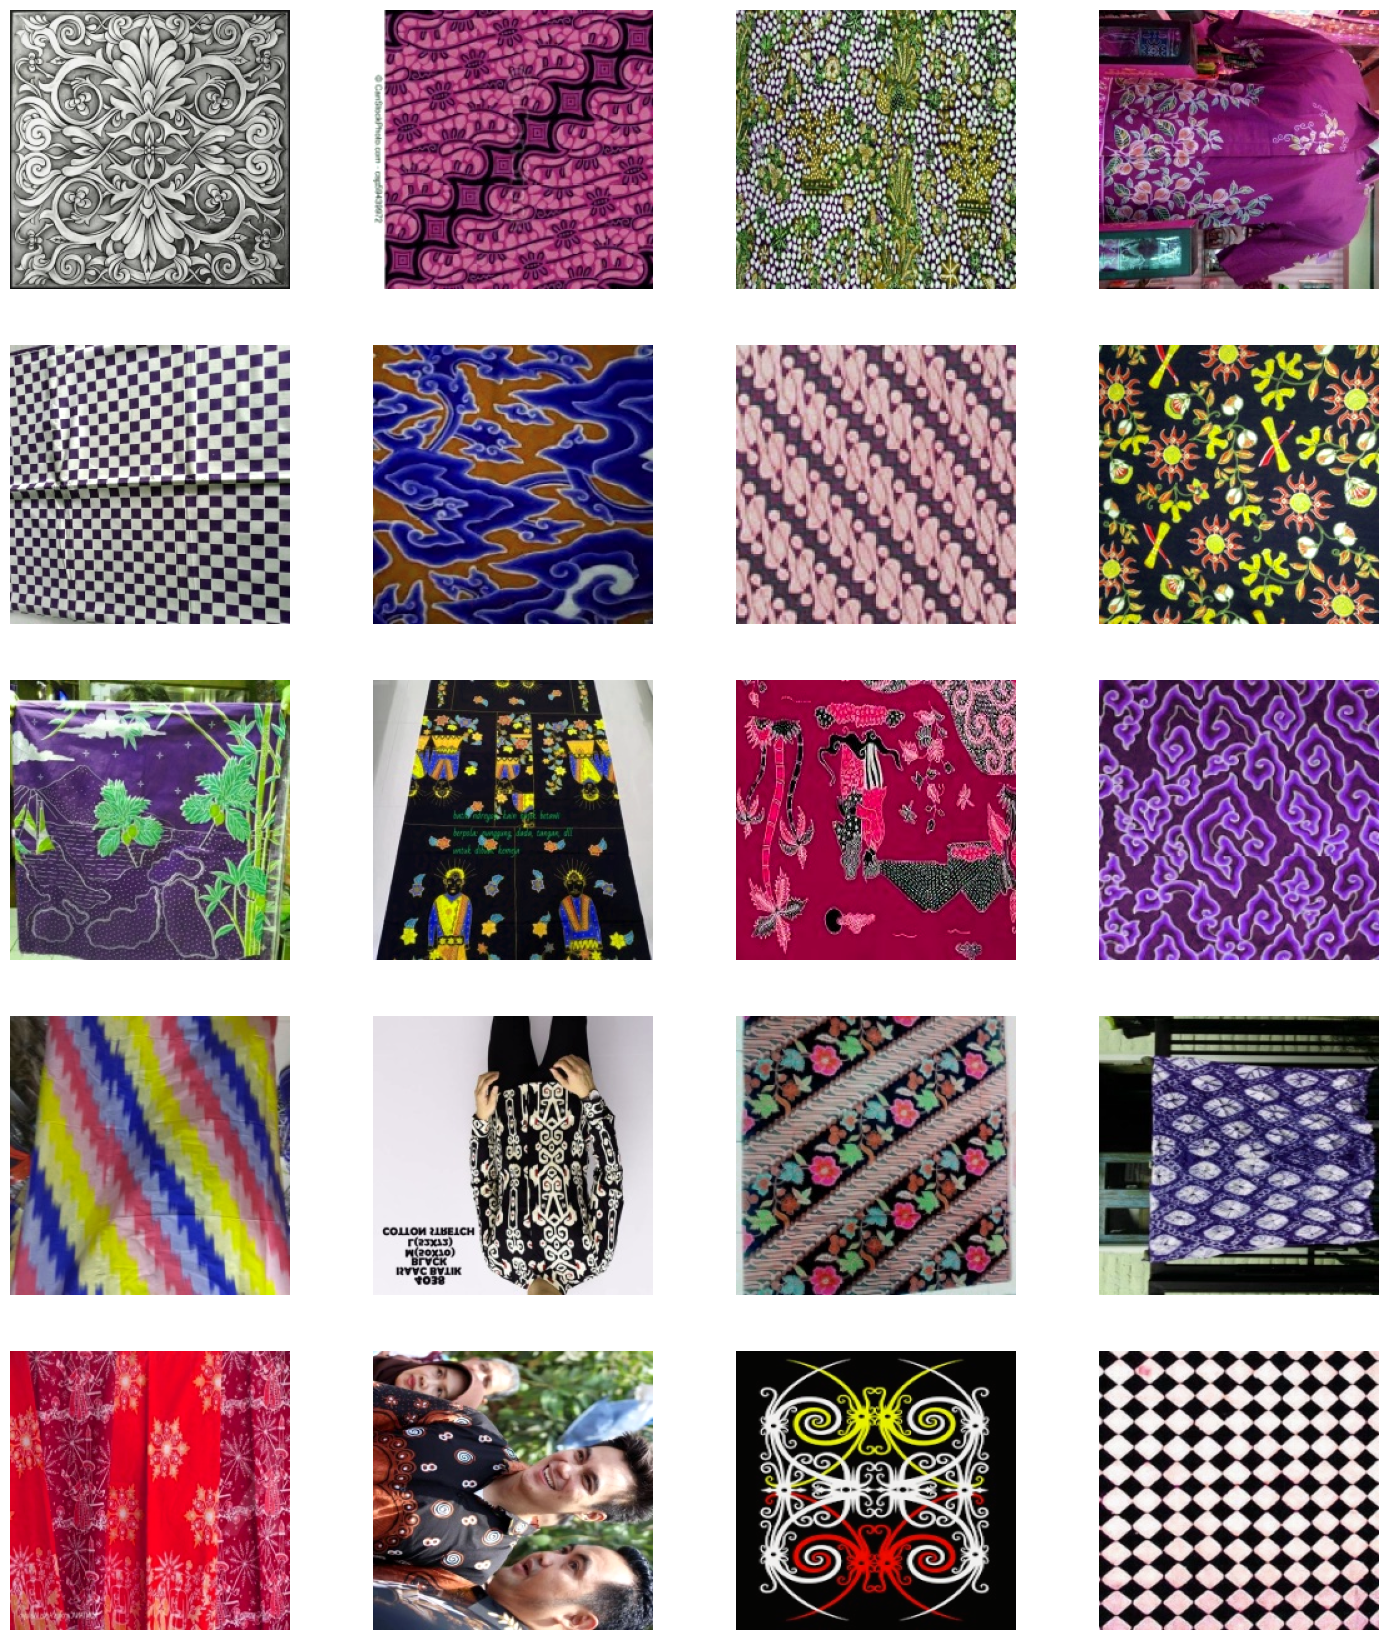

In [ ]:
plt.figure(figsize=(16, 20))

for i in range(20):
    img, label = train_generator.next()
    plt.subplot(5, 4, i+1)
    plt.imshow(img[0])
    plt.axis('off')

plt.show()

# Class Labelling

In [ ]:
motives_dict = train_generator.class_indices
print(motives_dict)

{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Cendrawasih': 2, 'Batik Dayak': 3, 'Batik Geblek Renteng': 4, 'Batik Ikat Celup': 5, 'Batik Insang': 6, 'Batik Kawung': 7, 'Batik Lasem': 8, 'Batik Megamendung': 9, 'Batik Pala': 10, 'Batik Parang': 11, 'Batik Poleng': 12, 'Batik Sekar Jagad': 13, 'Batik Tambal': 14}


# MobilenetV2 (Overfit Paling Mending)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

clear_session()

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Number of classes (adjust this according to your dataset)
num_classes = 15

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.8)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Training the model
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/300
33/33 [==============================] - 36s 455ms/step - loss: 6.5019 - accuracy: 0.0686 - val_loss: 2.7273 - val_accuracy: 0.1000 - lr: 1.0000e-04
Epoch 2/300
33/33 [==============================] - 15s 447ms/step - loss: 4.5908 - accuracy: 0.0800 - val_loss: 2.6181 - val_accuracy: 0.1367 - lr: 1.0000e-04
Epoch 3/300
33/33 [==============================] - 14s 438ms/step - loss: 3.8387 - accuracy: 0.0648 - val_loss: 2.5346 - val_accuracy: 0.1933 - lr: 1.0000e-04
Epoch 4/300
33/33 [==============================] - 14s 436ms/step - loss: 3.4523 - accuracy: 0.0800 - val_loss: 2.4961 - val_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 5/300
33/33 [==============================] - 14s 435ms/step - loss: 3.0799 - accuracy: 0.0914 - val_loss: 2.4572 - val_accuracy: 0.2067 - lr: 1.0000e-04
Epoch 6/300
33/33 [==============================] - 14s 432ms/step - loss: 2.9723 - accuracy: 0.0952 - val_loss: 2.4260 - val_accuracy: 0.2233 - lr: 1.0000e-04
Epoch 7/300
33/33 [===============

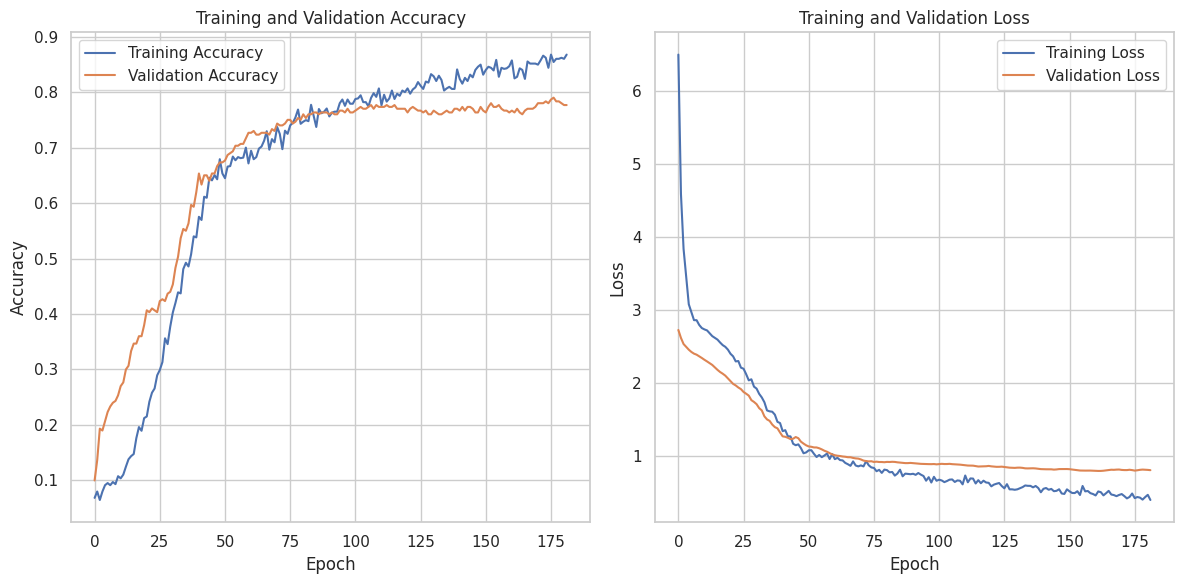

In [ ]:
import matplotlib.pyplot as plt

def plot(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function with your model's training history
plot(history)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Clear previous session
clear_session()

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Number of classes (adjust this according to your dataset)
num_classes = 15

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Reduced dropout rate
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Reduced dropout rate
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Reduced patience

# Training the model with frozen base model
history = model.fit(
    train_generator,
    epochs=500,  # Reduced epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Further training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=250,  # Reduced epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

In [ ]:
# Plotting function
def plot(history, history_fine):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function with your model's training history
plot(history, history_fine)